# Modelling with PyHealth (using NOTEEVENTS_ICD)

## Libraries

In [1]:
import pandas as pd
import numpy as np

In [ ]:
%pip install torch==2.1.0

In [1]:
import torch
print(torch.__version__)

# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

2.1.0+cpu


In [13]:
%pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://data.pyg.org/whl/torch-${TORCH}.html
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torch-geometric

In [2]:
# carica i dati dai file csv
noteevents = pd.read_csv('data/NOTEEVENTS_ICD.csv')
patients = pd.read_csv('data/PATIENTS.csv')

# seleziona i pazienti presenti in NOTEEVENTS_ICD
selected_patients = patients[patients['SUBJECT_ID'].isin(noteevents['SUBJECT_ID'].unique())]

# salva il risultato in un file csv
selected_patients.to_csv('data/PATIENTS_SEL.csv', index=False)


## Loading MIMIC-III into PyHealth

In [1]:
from pyhealth.datasets import MIMIC3Dataset

dataset = MIMIC3Dataset(
    root='data/',
    tables=["DIAGNOSES_ICD","PROCEDURES_ICD","PRESCRIPTIONS","NOTEEVENTS_ICD"],
    code_mapping={"NDC": ("ATC", {"target_kwargs": {"level": 4}})},
    # refresh_cache=True,
    # dev=True
)

In [2]:
dataset.stat()


Statistics of base dataset (dev=False):
	- Dataset: MIMIC3Dataset
	- Number of patients: 1560
	- Number of visits: 5014
	- Number of visits per patient: 3.2141
	- Number of events per visit in DIAGNOSES_ICD: 11.5987
	- Number of events per visit in PROCEDURES_ICD: 3.8771
	- Number of events per visit in PRESCRIPTIONS: 44.3879
	- Number of events per visit in NOTEEVENTS_ICD: 11.0782



'\nStatistics of base dataset (dev=False):\n\t- Dataset: MIMIC3Dataset\n\t- Number of patients: 1560\n\t- Number of visits: 5014\n\t- Number of visits per patient: 3.2141\n\t- Number of events per visit in DIAGNOSES_ICD: 11.5987\n\t- Number of events per visit in PROCEDURES_ICD: 3.8771\n\t- Number of events per visit in PRESCRIPTIONS: 44.3879\n\t- Number of events per visit in NOTEEVENTS_ICD: 11.0782\n'

## Reading retrieved dataset

In [4]:
# get patient dictionary
patient_dict = dataset.patients
print(list(patient_dict.keys()))
print(len(patient_dict))

['10055', '10071', '10077', '10144', '10160', '10174', '10197', '10207', '10254', '10285', '1029', '10302', '10304', '10310', '10328', '10342', '10369', '10414', '10434', '10442', '10478', '10487', '10488', '1050', '10594', '10612', '10618', '10634', '10635', '10637', '10660', '10679', '10687', '1069', '10742', '10774', '10820', '10832', '10859', '10884', '109', '10906', '10932', '10939', '10973', '10976', '10977', '11043', '11102', '11108', '11135', '11165', '11171', '112', '11205', '1122', '11234', '11236', '11242', '11255', '11318', '11342', '11346', '11421', '11442', '11464', '11479', '11588', '11590', '11604', '11623', '11634', '11716', '11763', '11764', '11778', '11818', '11825', '11830', '11838', '11861', '1187', '11876', '11885', '11892', '11897', '11932', '1197', '11970', '12039', '12076', '12110', '12113', '12125', '12149', '12198', '12203', '12217', '1223', '12281', '12344', '124', '12411', '12446', '12467', '12501', '12515', '12521', '12566', '12567', '12690', '12706', '127

In [5]:
# get the "10" patient
patient = patient_dict["4096"]
patient.gender, patient.birth_datetime, patient.ethnicity, patient.death_datetime, patient.visits
print(patient.visits)

OrderedDict([('124383', Visit 124383 from patient 4096 with 86 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD']), ('161677', Visit 161677 from patient 4096 with 109 events from tables ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD'])])


In [27]:
# get the visit list of this patient
visit_dict = patient.visits
print (list(visit_dict.keys()))

['124383', '161677']


In [28]:
# get the first visit
visit = visit_dict['124383']
visit.encounter_time, visit.available_tables, visit.num_events, visit.event_list_dict

(datetime.datetime(2170, 7, 20, 18, 9),
 ['DIAGNOSES_ICD', 'PROCEDURES_ICD', 'PRESCRIPTIONS', 'NOTEEVENTS_ICD'],
 86,
 {'DIAGNOSES_ICD': [Event with ICD9CM code 0389 from table DIAGNOSES_ICD,
   Event with ICD9CM code 5849 from table DIAGNOSES_ICD,
   Event with ICD9CM code 496 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4280 from table DIAGNOSES_ICD,
   Event with ICD9CM code 42731 from table DIAGNOSES_ICD,
   Event with ICD9CM code 566 from table DIAGNOSES_ICD,
   Event with ICD9CM code 99592 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4589 from table DIAGNOSES_ICD,
   Event with ICD9CM code 25080 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4019 from table DIAGNOSES_ICD,
   Event with ICD9CM code 2859 from table DIAGNOSES_ICD,
   Event with ICD9CM code 78009 from table DIAGNOSES_ICD,
   Event with ICD9CM code 4439 from table DIAGNOSES_ICD,
   Event with ICD9CM code 5939 from table DIAGNOSES_ICD,
   Event with ICD9CM code 71590 from table DIAGNOSES_ICD,
   Even

In [29]:
visit.get_code_list(table='NOTEEVENTS_ICD')

['V419',
 '4019',
 '4439',
 '43491',
 '78060',
 '51189',
 '7840',
 '78650',
 '78609',
 '78605',
 '78096',
 '2724',
 '53081',
 '71590',
 '5770',
 '496',
 '27800',
 '7823',
 '42761',
 '2512',
 '5849',
 '78791',
 '3301']

## Modelling data for task of Drug Recommendation

In [3]:
from pyhealth.tasks import drug_recommendation_mimic3_fn
from pyhealth.datasets import split_by_patient, get_dataloader

mimic3sample = dataset.set_task(task_fn=drug_recommendation_mimic3_fn) # use default task
train_ds, val_ds, test_ds = split_by_patient(mimic3sample, [0.8, 0.1, 0.1])

Generating samples for drug_recommendation_mimic3_fn: 100%|██████████| 1560/1560 [00:00<00:00, 12334.26it/s]


In [4]:
mimic3sample.stat()

Statistics of sample dataset:
	- Dataset: MIMIC3Dataset
	- Task: drug_recommendation_mimic3_fn
	- Number of samples: 2012
	- Number of patients: 906
	- Number of visits: 2012
	- Number of visits per patient: 2.2208
	- conditions:
		- Number of conditions per sample: 18.8827
		- Number of unique conditions: 2099
		- Distribution of conditions (Top-10): [('4019', 1225), ('4280', 1021), ('42731', 783), ('41401', 767), ('5849', 594), ('25000', 537), ('53081', 458), ('5990', 393), ('40391', 389), ('2724', 386)]
	- procedures:
		- Number of procedures per sample: 7.0055
		- Number of unique procedures: 733
		- Distribution of procedures (Top-10): [('3893', 1047), ('9904', 776), ('9604', 529), ('3995', 505), ('966', 484), ('9671', 477), ('3891', 295), ('9672', 292), ('3961', 267), ('9915', 257)]
	- drugs:
		- Number of drugs per sample: 30.2271
		- Number of unique drugs: 406
		- Distribution of drugs (Top-10): [('B05XA', 1792), ('B01AB', 1561), ('A02BC', 1494), ('N02BE', 1465), ('V06DC', 138

"Statistics of sample dataset:\n\t- Dataset: MIMIC3Dataset\n\t- Task: drug_recommendation_mimic3_fn\n\t- Number of samples: 2012\n\t- Number of patients: 906\n\t- Number of visits: 2012\n\t- Number of visits per patient: 2.2208\n\t- conditions:\n\t\t- Number of conditions per sample: 18.8827\n\t\t- Number of unique conditions: 2099\n\t\t- Distribution of conditions (Top-10): [('4019', 1225), ('4280', 1021), ('42731', 783), ('41401', 767), ('5849', 594), ('25000', 537), ('53081', 458), ('5990', 393), ('40391', 389), ('2724', 386)]\n\t- procedures:\n\t\t- Number of procedures per sample: 7.0055\n\t\t- Number of unique procedures: 733\n\t\t- Distribution of procedures (Top-10): [('3893', 1047), ('9904', 776), ('9604', 529), ('3995', 505), ('966', 484), ('9671', 477), ('3891', 295), ('9672', 292), ('3961', 267), ('9915', 257)]\n\t- drugs:\n\t\t- Number of drugs per sample: 30.2271\n\t\t- Number of unique drugs: 406\n\t\t- Distribution of drugs (Top-10): [('B05XA', 1792), ('B01AB', 1561), (

In [5]:
# create dataloaders (torch.data.DataLoader)
train_loader = get_dataloader(train_ds, batch_size=32, shuffle=True)
val_loader = get_dataloader(val_ds, batch_size=32, shuffle=False)
test_loader = get_dataloader(test_ds, batch_size=32, shuffle=False)

In [6]:
len(train_ds), len(val_ds), len(test_ds)

(1600, 213, 199)

## Our Model

In [7]:
%load_ext autoreload
%autoreload 2

import importlib
import pyhealth.models

importlib.reload(pyhealth.models)

<module 'pyhealth.models' from 'c:\\users\\giuse\\desktop\\msc-thesis-project\\proj_venv\\src\\pyhealth\\pyhealth\\models\\__init__.py'>

In [8]:
from pyhealth.models import GNN

model = GNN(
    dataset=mimic3sample,
    feature_keys=["procedures", "symptoms", "conditions"],
    label_key="drugs",
    k=0
)

c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\giuse\Desktop\MSc-Thesis-Project\proj_venv\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


GNN(
  (x_dict): X_Dict(
    (pat_emb): Embedding(906, 128)
    (vis_emb): Embedding(2012, 128)
    (symp_emb): Embedding(714, 128)
    (proc_emb): Embedding(733, 128)
    (dis_emb): Embedding(2099, 128)
    (drug_emb): Embedding(406, 128)
  )
  (layer): GNNLayer(
    (gnn): GraphModule(
      (conv1): ModuleDict(
        (patient__has__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__presents__symptom): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__has__disease): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__has_treat__procedure): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__has_received__drug): SAGEConv((-1, -1), 128, aggr=mean)
        (visit__rev_has__patient): SAGEConv((-1, -1), 128, aggr=mean)
        (symptom__rev_presents__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (disease__rev_has__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (procedure__rev_has_treat__visit): SAGEConv((-1, -1), 128, aggr=mean)
        (drug__rev_has_received__visit): S

Epoch 0 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-0, step-50 ---
loss: 0.1094


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.07it/s]

--- Eval epoch-0, step-50 ---


pr_auc_samples: 0.5967
loss: 0.1091
New best pr_auc_samples score (0.5967) at epoch-0, step-50



Epoch 1 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-1, step-100 ---
loss: 0.1048


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s]


--- Eval epoch-1, step-100 ---
pr_auc_samples: 0.6120
loss: 0.1063
New best pr_auc_samples score (0.6120) at epoch-1, step-100



Epoch 2 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-2, step-150 ---
loss: 0.1003


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]


--- Eval epoch-2, step-150 ---
pr_auc_samples: 0.6331
loss: 0.1008
New best pr_auc_samples score (0.6331) at epoch-2, step-150



Epoch 3 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-3, step-200 ---
loss: 0.0965


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.96it/s]

--- Eval epoch-3, step-200 ---
pr_auc_samples: 0.6454
loss: 0.0992
New best pr_auc_samples score (0.6454) at epoch-3, step-200


Epoch 4 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-4, step-250 ---
loss: 0.0925


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]

--- Eval epoch-4, step-250 ---
pr_auc_samples: 0.6547
loss: 0.0994
New best pr_auc_samples score (0.6547) at epoch-4, step-250



Epoch 5 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-5, step-300 ---
loss: 0.0893


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.45it/s]

--- Eval epoch-5, step-300 ---
pr_auc_samples: 0.6664
loss: 0.0966
New best pr_auc_samples score (0.6664) at epoch-5, step-300



Epoch 6 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-6, step-350 ---
loss: 0.0865


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.09it/s]


--- Eval epoch-6, step-350 ---
pr_auc_samples: 0.6802
loss: 0.0967
New best pr_auc_samples score (0.6802) at epoch-6, step-350



Epoch 7 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-7, step-400 ---
loss: 0.0851


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]


--- Eval epoch-7, step-400 ---
pr_auc_samples: 0.6880
loss: 0.0962
New best pr_auc_samples score (0.6880) at epoch-7, step-400



Epoch 8 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-8, step-450 ---
loss: 0.0837


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.26it/s]

--- Eval epoch-8, step-450 ---
pr_auc_samples: 0.6951
loss: 0.0948
New best pr_auc_samples score (0.6951) at epoch-8, step-450



Epoch 9 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-9, step-500 ---
loss: 0.0820


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.67it/s]

--- Eval epoch-9, step-500 ---


pr_auc_samples: 0.7055
loss: 0.0948
New best pr_auc_samples score (0.7055) at epoch-9, step-500



Epoch 10 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-10, step-550 ---
loss: 0.0804


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


--- Eval epoch-10, step-550 ---
pr_auc_samples: 0.7143
loss: 0.0931
New best pr_auc_samples score (0.7143) at epoch-10, step-550



Epoch 11 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-11, step-600 ---
loss: 0.0783


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


--- Eval epoch-11, step-600 ---
pr_auc_samples: 0.7179
loss: 0.0938
New best pr_auc_samples score (0.7179) at epoch-11, step-600



Epoch 12 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-12, step-650 ---
loss: 0.0766


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s]

--- Eval epoch-12, step-650 ---
pr_auc_samples: 0.7287
loss: 0.0916
New best pr_auc_samples score (0.7287) at epoch-12, step-650



Epoch 13 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-13, step-700 ---
loss: 0.0749


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.35it/s]

--- Eval epoch-13, step-700 ---
pr_auc_samples: 0.7329
loss: 0.0907
New best pr_auc_samples score (0.7329) at epoch-13, step-700


Epoch 14 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-14, step-750 ---
loss: 0.0737


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.51it/s]

--- Eval epoch-14, step-750 ---
pr_auc_samples: 0.7402
loss: 0.0904
New best pr_auc_samples score (0.7402) at epoch-14, step-750


Epoch 15 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-15, step-800 ---
loss: 0.0732


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.60it/s]

--- Eval epoch-15, step-800 ---
pr_auc_samples: 0.7433
loss: 0.0904
New best pr_auc_samples score (0.7433) at epoch-15, step-800



Epoch 16 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-16, step-850 ---
loss: 0.0713


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


--- Eval epoch-16, step-850 ---
pr_auc_samples: 0.7491
loss: 0.0905
New best pr_auc_samples score (0.7491) at epoch-16, step-850



Epoch 17 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-17, step-900 ---
loss: 0.0708


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.31it/s]


--- Eval epoch-17, step-900 ---
pr_auc_samples: 0.7517
loss: 0.0921
New best pr_auc_samples score (0.7517) at epoch-17, step-900



Epoch 18 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-18, step-950 ---
loss: 0.0701


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.24it/s]

--- Eval epoch-18, step-950 ---
pr_auc_samples: 0.7486
loss: 0.0909



Epoch 19 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-19, step-1000 ---
loss: 0.0696


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

--- Eval epoch-19, step-1000 ---


pr_auc_samples: 0.7553
loss: 0.0890
New best pr_auc_samples score (0.7553) at epoch-19, step-1000



Epoch 20 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-20, step-1050 ---
loss: 0.0689


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.13it/s]

--- Eval epoch-20, step-1050 ---


pr_auc_samples: 0.7559
loss: 0.0898
New best pr_auc_samples score (0.7559) at epoch-20, step-1050



Epoch 21 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-21, step-1100 ---
loss: 0.0688


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]

--- Eval epoch-21, step-1100 ---


pr_auc_samples: 0.7631
loss: 0.0885
New best pr_auc_samples score (0.7631) at epoch-21, step-1100



Epoch 22 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-22, step-1150 ---
loss: 0.0683


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


--- Eval epoch-22, step-1150 ---
pr_auc_samples: 0.7634
loss: 0.0893
New best pr_auc_samples score (0.7634) at epoch-22, step-1150



Epoch 23 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-23, step-1200 ---
loss: 0.0681


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.67it/s]

--- Eval epoch-23, step-1200 ---
pr_auc_samples: 0.7672
loss: 0.0888
New best pr_auc_samples score (0.7672) at epoch-23, step-1200



Epoch 24 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-24, step-1250 ---
loss: 0.0673


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]


--- Eval epoch-24, step-1250 ---
pr_auc_samples: 0.7669
loss: 0.0888



Epoch 25 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-25, step-1300 ---
loss: 0.0667


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.41it/s]

--- Eval epoch-25, step-1300 ---


pr_auc_samples: 0.7700
loss: 0.0886
New best pr_auc_samples score (0.7700) at epoch-25, step-1300



Epoch 26 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-26, step-1350 ---
loss: 0.0668


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


--- Eval epoch-26, step-1350 ---
pr_auc_samples: 0.7692
loss: 0.0883



Epoch 27 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-27, step-1400 ---
loss: 0.0659


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.30it/s]


--- Eval epoch-27, step-1400 ---
pr_auc_samples: 0.7689
loss: 0.0891



Epoch 28 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-28, step-1450 ---
loss: 0.0657


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


--- Eval epoch-28, step-1450 ---
pr_auc_samples: 0.7725
loss: 0.0898
New best pr_auc_samples score (0.7725) at epoch-28, step-1450



Epoch 29 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-29, step-1500 ---
loss: 0.0657


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]


--- Eval epoch-29, step-1500 ---
pr_auc_samples: 0.7696
loss: 0.0892



Epoch 30 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-30, step-1550 ---
loss: 0.0652


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 11.91it/s]


--- Eval epoch-30, step-1550 ---
pr_auc_samples: 0.7698
loss: 0.0904



Epoch 31 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-31, step-1600 ---
loss: 0.0647


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  8.86it/s]

--- Eval epoch-31, step-1600 ---


pr_auc_samples: 0.7743
loss: 0.0906
New best pr_auc_samples score (0.7743) at epoch-31, step-1600



Epoch 32 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-32, step-1650 ---
loss: 0.0643


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.34it/s]

--- Eval epoch-32, step-1650 ---
pr_auc_samples: 0.7730
loss: 0.0910



Epoch 33 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-33, step-1700 ---
loss: 0.0638


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.74it/s]


--- Eval epoch-33, step-1700 ---
pr_auc_samples: 0.7716
loss: 0.0918



Epoch 34 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-34, step-1750 ---
loss: 0.0642


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


--- Eval epoch-34, step-1750 ---
pr_auc_samples: 0.7748
loss: 0.0913
New best pr_auc_samples score (0.7748) at epoch-34, step-1750



Epoch 35 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-35, step-1800 ---
loss: 0.0631


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


--- Eval epoch-35, step-1800 ---
pr_auc_samples: 0.7798
loss: 0.0914
New best pr_auc_samples score (0.7798) at epoch-35, step-1800



Epoch 36 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-36, step-1850 ---
loss: 0.0632


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s]


--- Eval epoch-36, step-1850 ---
pr_auc_samples: 0.7747
loss: 0.0950



Epoch 37 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-37, step-1900 ---
loss: 0.0626


Evaluation: 100%|██████████| 7/7 [00:00<00:00, 10.80it/s]


--- Eval epoch-37, step-1900 ---
pr_auc_samples: 0.7793
loss: 0.0910



Epoch 38 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-38, step-1950 ---
loss: 0.0625


Evaluation: 100%|██████████| 7/7 [00:00<00:00,  9.62it/s]


--- Eval epoch-38, step-1950 ---
pr_auc_samples: 0.7787
loss: 0.0934



Epoch 39 / 40:   0%|          | 0/50 [00:00<?, ?it/s]

--- Train epoch-39, step-2000 ---
loss: 0.0628


Evaluation: 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

--- Eval epoch-39, step-2000 ---
pr_auc_samples: 0.7801
loss: 0.0912
New best pr_auc_samples score (0.7801) at epoch-39, step-2000


Loaded best model


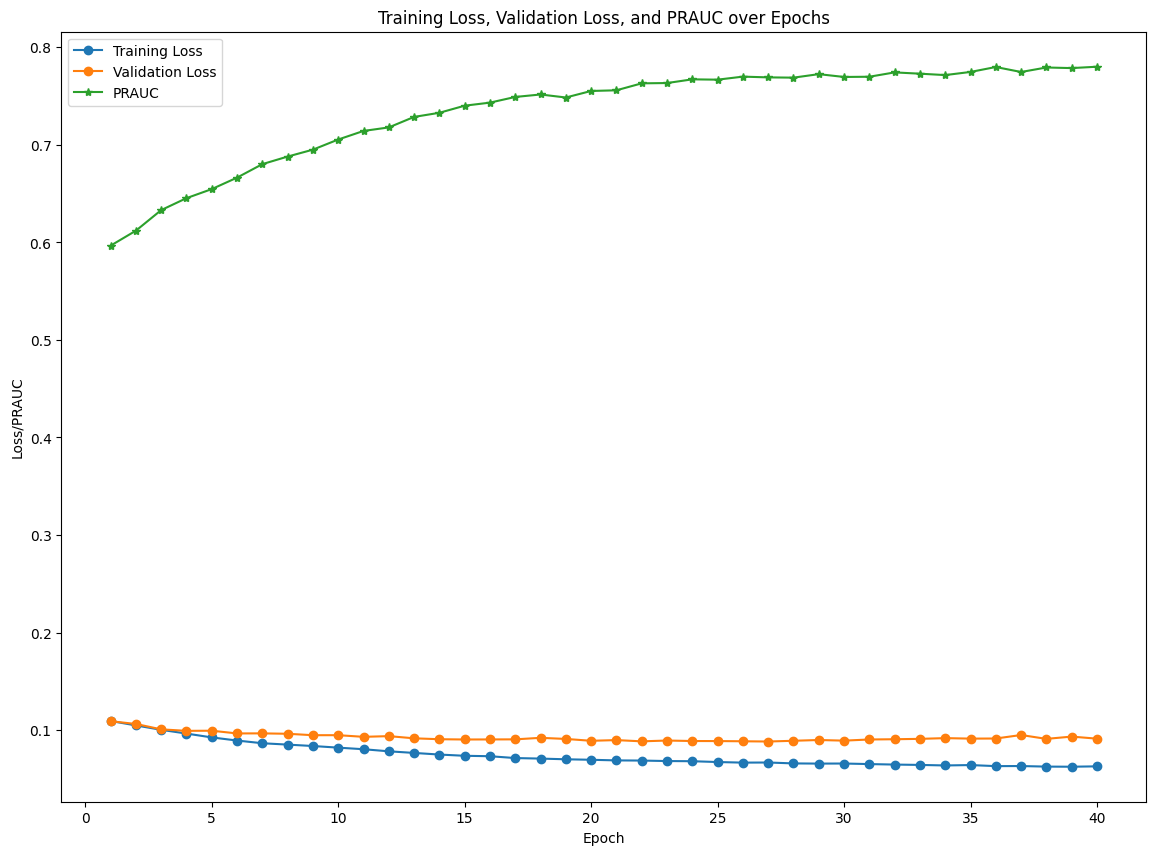

In [54]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    model_name="gnn",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=40,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
    monitor_criterion="max",
)

### Results

loss: 0.0714
New best pr_auc_samples score (0.7785) at epoch-49, step-2550

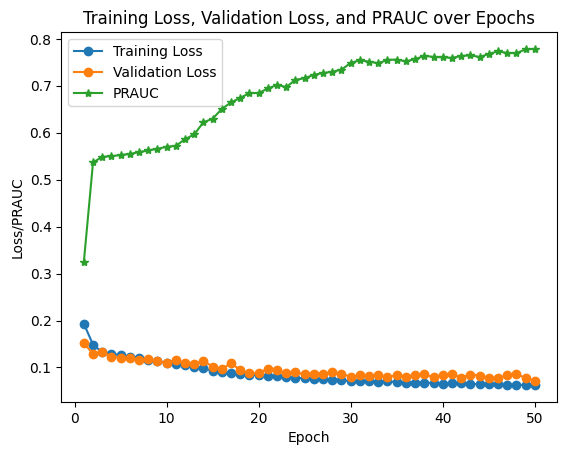

### Inference

In [55]:
from pyhealth.metrics import multilabel_metrics_fn

y_true, y_prob, loss = trainer.inference(test_loader)
print(loss)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 12.30it/s]

0.0775440473641668


In [56]:
print(y_true.shape)

print(y_true[y_true == 0].shape)
print(y_true[y_true == 1].shape)

(199, 406)
(74920,)
(5874,)


In [57]:
print(y_prob.shape)
print(y_prob.max())
print(y_prob.min())

(199, 406)
0.99837816
1.1807133e-11


In [58]:
print(y_true)
print("------------------")
threshold = 0.5
y_prob_threshold = (y_prob >= threshold).astype(float)
print(y_prob_threshold)
print(y_prob_threshold[y_prob_threshold == 0].shape)
print(y_prob_threshold[y_prob_threshold == 1].shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]
------------------
[[0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]]
(71669,)
(9125,)


In [59]:
# risultati
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples", "precision_samples", "recall_samples"]
multilabel_metrics_fn(y_true, y_prob, metrics=metrics, threshold=0.5)

{'accuracy': 0.9436963140827289,
 'f1_samples': 0.6618739596762372,
 'pr_auc_samples': 0.7759329028023326,
 'jaccard_samples': 0.5134767624572804,
 'precision_samples': 0.5567423575523833,
 'recall_samples': 0.8844735859106491}

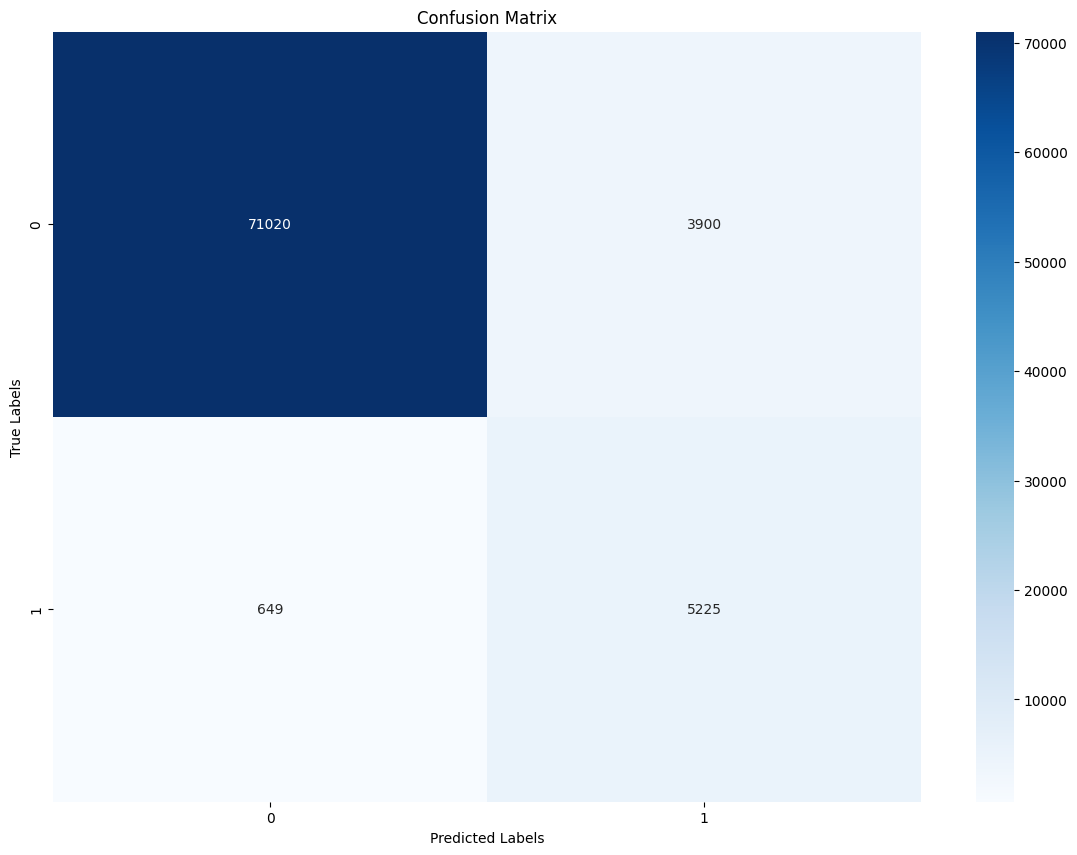

In [60]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_true.flatten(), y_prob_threshold.flatten())

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Interpret with HeteroExplainer

In [ ]:
%load_ext autoreload
%autoreload 2

import importlib
import pyhealth.explainer

importlib.reload(pyhealth.explainer)

In [150]:
from pyhealth.explainer import HeteroGraphExplainer

explainer = HeteroGraphExplainer(
    dataset=test_loader.dataset, 
    model=model, 
    label_key="drugs",
    k=0
)

In [151]:
explainer.explain(
    n=32
)

Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to './explainability_results/feature_importance_20231215_183935.png'
Edge to predict: tensor([81, 98])
Label to predict: 1
Label predicted: 1 because [0.76517266]


In [152]:
explainer.explain_graph()

./explainability_results/explain_graph20231215_183935.html


In [155]:
explainer.explain_metrics(metrics=["Fidelity", "Fidelity_AUC", "Characterization_Score", "Unfaithfulness"])

Fidelity Positive: 0.09362083673477173
Fidelity Negative: 0.07270342111587524
Fidelity AUC: 0.0
Characterization Score: 0.17007111503489203
Unfaithfulness Score: 6.943941116333008e-05


In [154]:
explainer.explain_results()

patient_38
visit_81
visit_139
symptom_179: Other encephalopathy
visit_45
symptom_180: Unspecified iridocyclitis
symptom_181: Unspecified disorder of globe
symptom_69: Splenomegaly
visit_130
symptom_118: Headache
visit_186
visit_87
symptom_240: Intermediate coronary syndrome
visit_34
symptom_157: Epilepsy, unspecified, without mention of intractable epilepsy
visit_35
symptom_156: Infectious colitis, enteritis, and gastroenteritis
visit_114
symptom_2: Unspecified essential hypertension
visit_80
disease_366: Infection with microorganisms resistant to penicillins
visit_127
disease_290: Bipolar disorder, unspecified
visit_47
disease_255: Other chronic pain
visit_134
disease_518: Incisional hernia without mention of obstruction or gangrene
visit_79
disease_353: Primary pulmonary hypertension
visit_166
disease_583: Secondary malignant neoplasm of brain and spinal cord
visit_151
disease_557: Other specified forms of pleural effusion, except tuberculous
disease_214: Proteus (mirabilis) (morgani

## Baseline Models

Here we can use the models having the same input built in the previous cells. We tried GRASP, SafeDrug, Transformer, and so on. And evaluate them performance with several metrics.

### Transformer

**- Transformer without symptoms**

In [219]:
from pyhealth.models import Transformer

model_tr = Transformer(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)

**- Transformer with symptoms**

In [17]:
from pyhealth.models import Transformer

model_tr_symptoms = Transformer(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures", "symptoms"],
    label_key="drugs",
    mode="multilabel",
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_tr = Trainer(model=model_tr)
trainer_tr.train(
    model_name="transformer",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2737
New best pr_auc_samples score (0.6465) at epoch-9, step-510

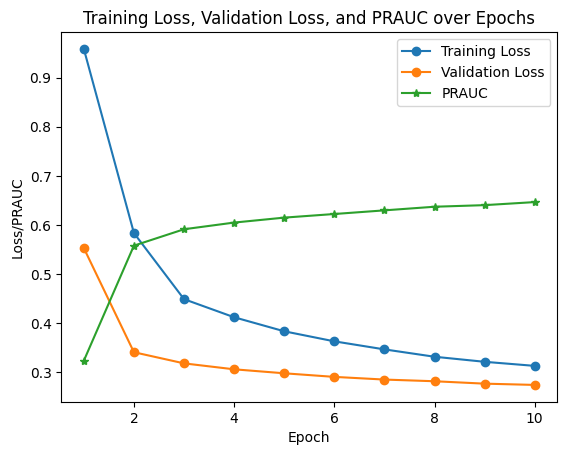

**- Training with symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_tr_symptoms = Trainer(model=model_tr_symptoms)
trainer_tr_symptoms.train(
    model_name="transformer",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=50,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
    monitor_criterion="max",
)

### Results

loss: 0.1799
New best pr_auc_samples score (0.5844) at epoch-40, step-2091

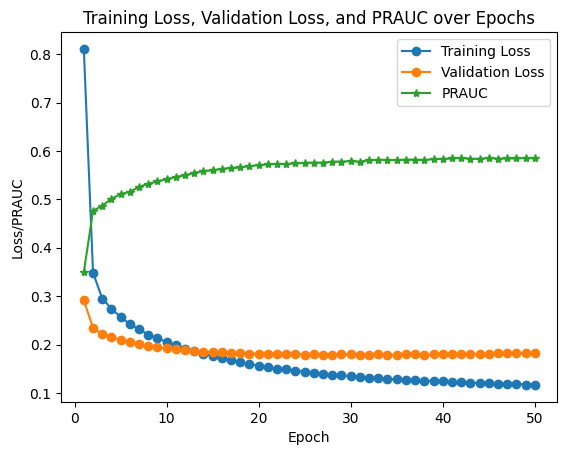

**- Transformer Evaluation**

In [223]:
### Without Symptoms - loss 0.3239 - time: 0m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_tr, y_prob_tr, loss_tr = trainer_tr.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_tr, y_prob_tr, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 64.07it/s]


{'accuracy': 0.8929554968054637,
 'f1_samples': 0.5066958446595764,
 'pr_auc_samples': 0.6258955924552839,
 'jaccard_samples': 0.34884642635231966}

In [19]:
### With Symptoms - loss 0.3192 - time: 0m 9s
from pyhealth.metrics import multilabel_metrics_fn

y_true_tr_s, y_prob_tr_s, loss_tr_s = trainer_tr_symptoms.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_tr_s, y_prob_tr_s, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 76.44it/s]


{'accuracy': 0.9381360806181391,
 'f1_samples': 0.48055933544795987,
 'pr_auc_samples': 0.6114930832175687,
 'jaccard_samples': 0.3284850321801622}

### SafeDrug

**- SafeDrug without symptoms**

In [225]:
from pyhealth.models import SafeDrug

model_safe = SafeDrug(
    dataset=mimic3sample
)

**- SafeDrug with symptoms**

In [226]:
from pyhealth.models import SafeDrug_Mod

model_safe_symptoms = SafeDrug_Mod(
    dataset=mimic3sample
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_safe = Trainer(model=model_safe)
trainer_safe.train(
    model_name="safedrug",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2503
New best pr_auc_samples score (0.6564) at epoch-8, step-459

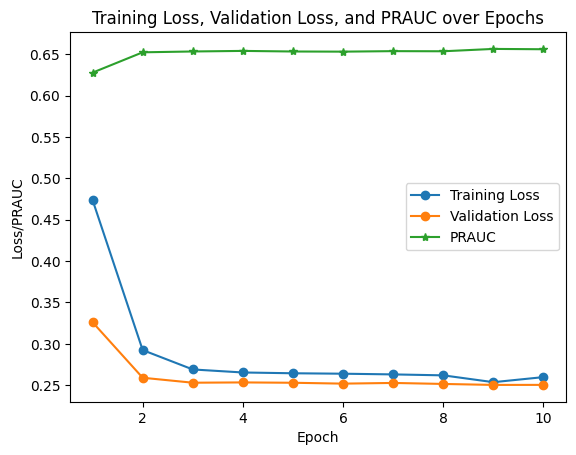

**- Training with symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_safe_symptoms = Trainer(model=model_safe_symptoms)
trainer_safe_symptoms.train(
    model_name="safedrug",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2523
New best pr_auc_samples score (0.6550) at epoch-6, step-357

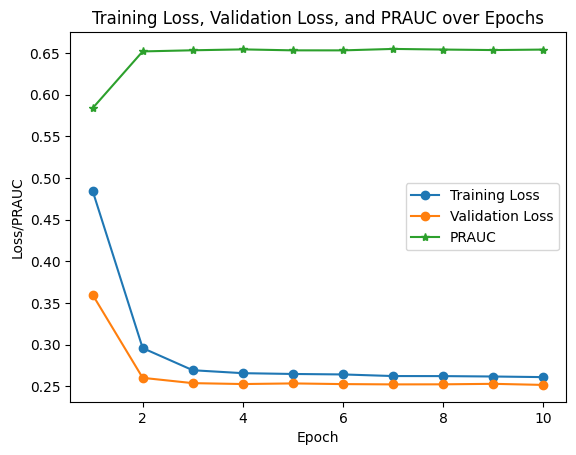

**- SafeDrug Evaluation**

In [229]:
### Without Symptoms - loss 0.2672 - time: 2m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_safe, y_prob_safe, loss_safe = trainer_safe.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_safe, y_prob_safe, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]


{'accuracy': 0.8926801057501652,
 'f1_samples': 0.46661275056800083,
 'pr_auc_samples': 0.6270758763872015,
 'jaccard_samples': 0.31076166173689124}

In [230]:
### With Symptoms - loss 0.2666 - time: 2m 0s
from pyhealth.metrics import multilabel_metrics_fn

y_true_safe_s, y_prob_safe_s, loss_safe_s = trainer_safe_symptoms.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_safe_s, y_prob_safe_s, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


{'accuracy': 0.8925148711169861,
 'f1_samples': 0.47263706593544114,
 'pr_auc_samples': 0.6248807689518094,
 'jaccard_samples': 0.3164571303390051}

### GAMENet

### GRASP

### RETAIN

### GRAM

### KAME

### MoleRec

### RNN

**- RNN without symptoms**

In [241]:
from pyhealth.models import RNN

model_rnn = RNN(
    dataset=mimic3sample,
    feature_keys=["conditions", "procedures"],
    label_key="drugs",
    mode="multilabel",
)

**- Training without symptoms**

In [ ]:
from pyhealth.trainer import Trainer

trainer_rnn = Trainer(model=model_rnn)
trainer_rnn.train(
    model_name="rnn",
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=10,
    optimizer_params = {"lr": 2 * 1e-4},
    monitor="pr_auc_samples",
)

loss: 0.2564
New best pr_auc_samples score (0.6729) at epoch-9, step-510

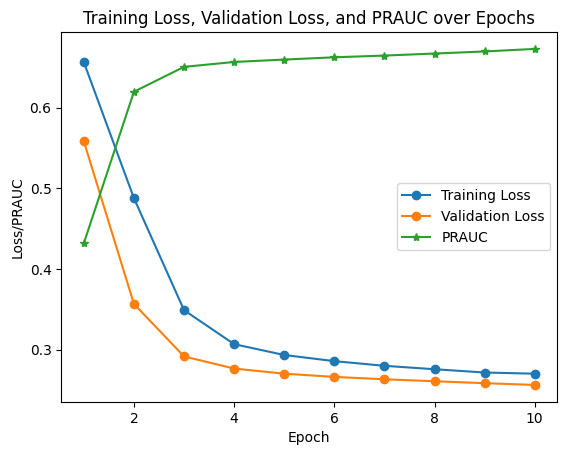

**- RNN Evaluation**

In [243]:
### Without Symptoms - loss 0.3239 - time: 0m 6s
from pyhealth.metrics import multilabel_metrics_fn

y_true_rnn, y_prob_rnn, loss_rnn = trainer_rnn.inference(test_loader)
metrics = ["accuracy", "f1_samples", "pr_auc_samples", "jaccard_samples"]
multilabel_metrics_fn(y_true_rnn, y_prob_rnn, metrics=metrics)

Evaluation: 100%|██████████| 7/7 [00:00<00:00, 136.85it/s]


{'accuracy': 0.8959572593082177,
 'f1_samples': 0.5208913438646415,
 'pr_auc_samples': 0.6492154854289413,
 'jaccard_samples': 0.361292772853502}

## Let'see some recommendation...

In [ ]:
import numpy as np
import pandas as pd
from pyhealth.medcode import InnerMap

# initialize an InnerMap
atc = InnerMap.load("ATC")

sorted_indices = []
for i in range(len(y_prob)):
    top_indices = np.argsort(y_prob[i, :])[::-1][:10]
    sorted_values = y_prob[i, top_indices]
    sorted_indices.append(top_indices)

patient_ids = []
visit_ids = []
rec_drug = []

# get the list of all drugs in the dataset
list_drugs = mimic3sample.get_all_tokens('drugs')

# iterate over the top indexes for each sample in test_ds
for sample, top in zip(test_ds, sorted_indices):
   
    # append the patient id and visit id to their respective lists
    patient_ids.append(sample['patient_id'])
    visit_ids.append(sample['visit_id'])
   
    # create an empty list to store the recommended drugs for this sample
    sample_rec_drug = []
   
    # iterate over the top indexes for this sample
    for i in top:
       
        # append the drug at the i-th index to the recommended drugs list for this sample
        sample_rec_drug.append(list_drugs[i])
   
    # append the recommended drugs for this sample to the recommended drugs list
    rec_drug.append(sample_rec_drug)

# create a dataframe with the patient ids, visit ids, and recommended drugs
df_rec_drug = pd.DataFrame({'patient_id': patient_ids, 'visit_id': visit_ids, 'rec_drug': rec_drug})
df_rec_drug

In [125]:
from pyhealth.medcode import InnerMap

# initialize an InnerMap
atc = InnerMap.load("ATC")

# select a patient from df_rec_drug
patient_id = 10884
visit_id = 150905
patient_df = df_rec_drug[df_rec_drug['patient_id'].astype(int)==patient_id]
patient_df = patient_df[patient_df['visit_id'].astype(int)==visit_id]

# iterate over the recommended drugs for the selected patient
for drugs in patient_df['rec_drug']:
    # lookup the ATC code for each drug and print it
    for drug in drugs:
        print(f"{drug}: {atc.lookup(drug)}")

B05XA: Electrolyte solutions
N03AX: Other antiepileptics in ATC
M04AC: Preparations with no effect on uric acid metabolism
M03BA: Carbamic acid esters, centrally acting muscle relaxants
G04CA: Alpha-adrenoreceptor antagonists, benign prostatic hypertrophy
J01EE: Combinations of sulfonamides and trimethoprim, incl. derivatives
N02BE: Anilide analgesics and antipyretics
B01AB: Heparin group antithrombotic drugs
N05CF: Benzodiazepine related hypnotics and sedatives
A02BC: Proton pump inhibitors for peptic ulcer and GORD


In [124]:
from pyhealth.medcode import InnerMap

# select a patient from df_rec_drug
patient_id = 10884
visit_id = 150905

for sample in test_ds:
    if (sample['patient_id'] == str(patient_id)) and (sample['visit_id'] == str(visit_id)):
        conditions = sample['conditions']
        procedures = sample['procedures']
        symptoms = sample['symptoms']

# initialize an InnerMap
icd9cm = InnerMap.load("ICD9CM")
i=0
for condition in conditions:
    for code in condition:
        print(f"Condition {i}: {icd9cm.lookup(code)}")
        i+=1

# initialize an InnerMap
icd9pr = InnerMap.load("ICD9PROC")
i=0
for procedure in procedures:
    for code in procedure:
        print(f"Procedure {i}: {icd9pr.lookup(code)}")
        i+=1

i=0
for symptom in symptoms:
    for code in symptom:
        print(f"Symptom {i}: {icd9cm.lookup(code)}")
        i+=1

Condition 0: Acute and subacute necrosis of liver
Condition 1: Alcoholic cirrhosis of liver
Condition 2: Hepatorenal syndrome
Condition 3: Acute kidney failure with lesion of tubular necrosis
Condition 4: Congestive heart failure, unspecified
Condition 5: Hyposmolality and/or hyponatremia
Condition 6: Chronic kidney disease, unspecified
Condition 7: Toxic encephalopathy
Condition 8: Hepatic encephalopathy
Condition 9: Calculus of gallbladder with other cholecystitis, without mention of obstruction
Condition 10: Ascites
Condition 11: Acquired coagulation factor deficiency
Condition 12: Thrombocytopenia, unspecified
Condition 13: Unspecified essential hypertension
Condition 14: Other specified disorders of pancreatic internal secretion
Condition 15: Adrenal cortical steroids causing adverse effects in therapeutic use
Condition 16: Acute alcoholic intoxication in alcoholism, in remission
Condition 17: Esophageal reflux
Condition 18: Personal history of urinary calculi
Condition 19: Aphasi